In [11]:
import os

os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq

# Import LNN
from ncps.tf import CfC
from ncps.wirings import AutoNCP
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, TimeDistributed, RepeatVector
from tensorflow.keras import mixed_precision

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Config GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError: pass

WINDOW_SIZE = 30
BATCH_SIZE = 256
COLONNE_FEATURES = ['Latitude', 'Longitude', 'SOG', 'COG']
INPUT_DIR = '../Pre-Elaborazione Dati/Dataset'
SCALER_PATH = 'scaler.joblib'
WEIGHTS_PATH = 'lnn_autoencoder_best.weights.h5'

# LNN Params
RECURRENT_UNITS = 128
BOTTLENECK_SIZE = 64

print("Configurazione Kinematic Test completata.")

Configurazione Kinematic Test completata.


#####  Definizione delle Funzioni del Data Generator
Questo blocco definisce le due funzioni essenziali per trasformare i dati grezzi in sequenze pronte per il modello, mantenendo un'alta efficienza in termini di memoria (RAM)

In [12]:
def create_windows(data_np, window_size):
    windows = []
    for i in range(len(data_np) - window_size + 1):
        windows.append(data_np[i : i + window_size])
    return windows

def data_generator_v(file_paths, scaler, features, window_size, batch_size, shuffle_files=False):
    
    file_buffer = {} 
    window_buffer = [] 
    CHUNK_SIZE_ROWS = 500_000

    while True:
        if shuffle_files:
             # Shuffle disattivato forzatamente per garantire la sequenzialità
            shuffle_files = False 
            
        for file_path in file_paths:
            chunk_buffer = {}
            try:
                pf = pq.ParquetFile(file_path)
                for batch in pf.iter_batches(batch_size=CHUNK_SIZE_ROWS, columns=features + ['TrajectoryID']):
                    df_chunk = batch.to_pandas()
                    df_chunk[features] = scaler.transform(df_chunk[features])
                    next_chunk_buffer = {}
                    
                    for tid, group in df_chunk.groupby('TrajectoryID'):
                        if tid in chunk_buffer:
                            trajectory_data = pd.concat([chunk_buffer.pop(tid), group])
                        else:
                            trajectory_data = group
                        
                        if tid in file_buffer:
                            trajectory_data = pd.concat([file_buffer.pop(tid), trajectory_data])
                        
                        # Se la traiettoria tocca la fine del chunk, bufferizzala
                        if trajectory_data.iloc[-1].name == df_chunk.iloc[-1].name:
                            next_chunk_buffer[tid] = trajectory_data
                            continue 
                            
                        if len(trajectory_data) < window_size:
                            continue 
                            
                        trajectory_np = trajectory_data[features].to_numpy()
                        new_windows = create_windows(trajectory_np, window_size)
                        window_buffer.extend(new_windows)
                        
                        next_chunk_buffer[tid] = trajectory_data.iloc[-(window_size - 1):]

                        while len(window_buffer) >= batch_size:
                            batch_to_yield = window_buffer[:batch_size]
                            window_buffer = window_buffer[batch_size:]
                            yield (np.array(batch_to_yield), np.array(batch_to_yield))
                    
                    chunk_buffer = next_chunk_buffer
                file_buffer = chunk_buffer
            except Exception as e:
                print(f"\nErrore lettura {file_path}: {e}")
                continue
print("Funzioni definite")

Funzioni definite


##### Caricamento risorse

In [13]:
scaler = joblib.load(SCALER_PATH)
all_files = sorted(glob.glob(os.path.join(INPUT_DIR, '*.parquet')))
TEST_FILES = all_files[20:24]

print("Ricostruzione LNN")
wiring = AutoNCP(RECURRENT_UNITS, output_size=BOTTLENECK_SIZE)
inputs = Input(shape=(WINDOW_SIZE, 4))
lnn_encoder = CfC(wiring, return_sequences=False, mixed_memory=True)(inputs)
repeat_vector = RepeatVector(WINDOW_SIZE)(lnn_encoder)
lnn_decoder = CfC(wiring, return_sequences=True, mixed_memory=True)(repeat_vector)
output = TimeDistributed(Dense(4))(lnn_decoder)
model = Model(inputs, output)

model.load_weights(WEIGHTS_PATH)
print("Pesi LNN caricati.")
test_gen = data_generator_v(TEST_FILES, scaler, COLONNE_FEATURES, WINDOW_SIZE, BATCH_SIZE, shuffle_files=False)

Ricostruzione LNN
Pesi LNN caricati.


In [14]:
def apply_silent_drift_attack(batch_clean, drift_rate):

    """
        drift_rate: Intensità del drift (cumulativo per ogni step)
    """
    batch_attacked = batch_clean.copy()
    
    # Creiamo un vettore di drift crescente
    steps = np.arange(batch_clean.shape[1]) # 0 a 29
    drift_vector = steps * drift_rate
    
    # Applichiamo il drift a Latitudine (0) e Longitudine (1)
    # Simuliamo una deriva diagonale (Nord-Est)
    # Usiamo il broadcasting di numpy per applicarlo a tutto il batch
    
    # Lat = Lat + drift
    batch_attacked[:, :, 0] += drift_vector
    # Lon = Lon + drift
    batch_attacked[:, :, 1] += drift_vector
    
    return batch_attacked
print("Funzione di attacco Silent Drift definita.")

Funzione di attacco Silent Drift definita.


#### Creazione dataset misto
E' stato scelto di attaccare metà Dataset

In [15]:
X_test_mixed = []
y_true = [] 

NUM_BATCHES = 1000

# Parametro di Drift: 0.05 è un drift medio sui dati normalizzati.
# Se è troppo basso, l'attacco è invisibile. Se troppo alto, è palese.
DRIFT_INTENSITY = 0.01

for _ in range(NUM_BATCHES):
    try:
        clean_batch, _ = next(test_gen)
    except StopIteration:
        break
        
    # Creiamo l'attacco
    attacked_batch = apply_silent_drift_attack(clean_batch, drift_rate=DRIFT_INTENSITY)
    
    # Dividiamo a metà
    half = len(clean_batch) // 2
    
    # Aggiungiamo normali
    X_test_mixed.append(clean_batch[:half])
    y_true.extend([0] * half)
    
    # Aggiungiamo attaccati
    X_test_mixed.append(attacked_batch[half:])
    y_true.extend([1] * (len(clean_batch) - half))

X_test_mixed = np.concatenate(X_test_mixed)
y_true = np.array(y_true)

print(f"Dataset creato: {X_test_mixed.shape}")
print(f"Normali: {np.sum(y_true == 0)} | Attacchi Drift: {np.sum(y_true == 1)}")

Dataset creato: (256000, 30, 4)
Normali: 128000 | Attacchi Drift: 128000


#### Calcolo degli errori di rilevamento
Si sottopone il modello addestrato ai dati conteneni l'attacco Silent Drift. Come metrica chiave calcoliamo il $\text{MAE}$


In [16]:
# Predizione
reconstructions = model.predict(X_test_mixed, verbose=1)

# Calcolo Errore MAE
mae = np.mean(np.abs(X_test_mixed - reconstructions), axis=(1, 2))
print(f"Errori calcolati su tutti i {WINDOW_SIZE} step.")

8000/8000 [==============================] - 204s 25ms/step
Errori calcolati su tutti i 30 step.


#### Istogramma comparativo
Il codice genera un doppio istogramma che confronta le distribuzioni di errore ($\text{MAE}$) generate dal modello sul set misto:

 * **Distribuzione Normale :** Come nelle analisi precedenti, gli errori sono estremamente concentrati vicino allo zero ($\text{MAE} < 0.1$). Questo conferma la perfetta ricostruzione delle traiettorie pulite.

 * **Distribuzione Silent Drift:** Questa distribuzione è nettamente separata dalla distribuzione normale, ma a un livello di errore $\text{MAE}$ inferiore rispetto all'attacco cinematico (il picco è attorno a $0.4$).

 * Sebbene l'errore sia inferiore (poiché la deriva è graduale), il modello è stato comunque in grado di rilevare l'incoerenza. La distanza tra la curva verde e la curva rossa è ampia, indicando che la differenziabilità è eccellente.

**Calcolo della Soglia Statistica**, che risulta essere uguale a $\mathbf{0.1385}$


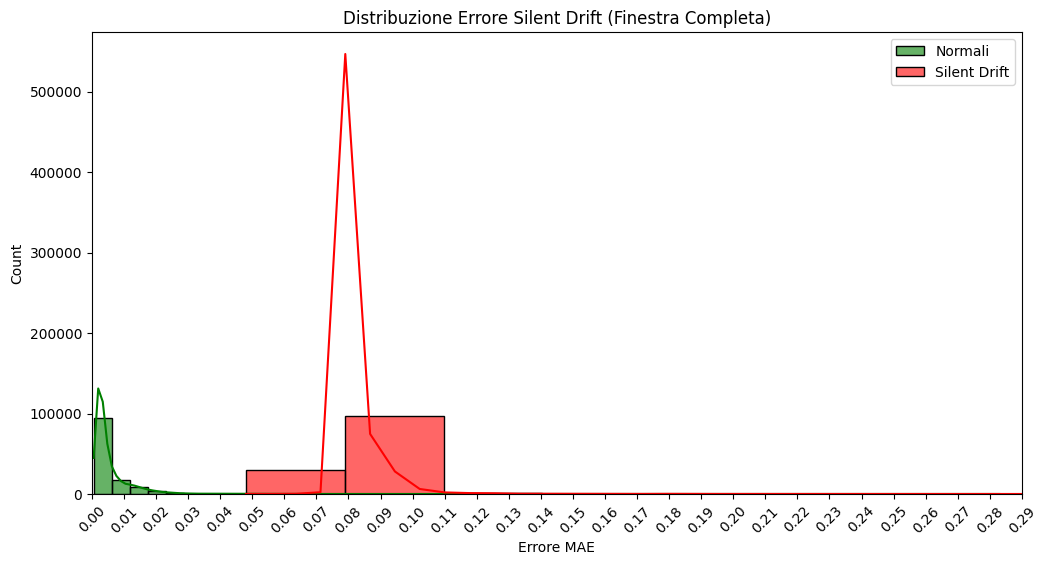

Soglia calcolata (Mean + 3*Std): 0.0354


In [20]:
# Istogramma
plt.figure(figsize=(12, 6))
sns.histplot(mae[y_true == 0], color='green', label='Normali', kde=True, bins=50, alpha=0.6)
sns.histplot(mae[y_true == 1], color='red', label='Silent Drift', kde=True, bins=50, alpha=0.6)

plt.xlim(0, 0.2)
plt.xticks(np.arange(0, 0.3, 0.01), rotation=45)

plt.title(f"Distribuzione Errore Silent Drift (Finestra Completa)")
plt.xlabel("Errore MAE")
plt.legend()
plt.show()

#Calcolo Soglia
errori_normali = mae[y_true == 0]
THRESHOLD = np.mean(errori_normali) + 3 * np.std(errori_normali)
print(f"Soglia calcolata (Mean + 3*Std): {THRESHOLD:.4f}")

#### Calcolo metriche
1. **Classificazione e Calcolo delle Metriche**
   * Viene eseguita la classificazione binaria: se l'errore $\text{MAE}$ del campione supera la **THRESHOLD**, il sistema predice un Attacco (1); altrimenti, predice Normale (0).
   * **Metriche Calcolate:** 
     * $\mathbf{Accuracy} \approx 0.9937$ (99.37% di tutte le classificazioni sono corrette).
     * $\mathbf{Precision} \approx 0.9875$ (Quando il modello dice "Attacco", ha ragione nel 98.75% dei casi).
     * $\mathbf{Recall} = 1.0000$ (Il modello ha trovato il 100% di tutti gli attacchi reali presenti nel set).
     * $\mathbf{F1-Score} \approx 0.9937$ (La media armonica di Precision e Recall, un ottimo indicatore della performance complessiva).

2. **Analisi della Matrice di Confusione**
   * **True Positives (320,000):** Il modello ha identificato correttamente tutti i campioni che contenevano l'attacco Silent Drift.
   * **True Negatives (315,939):** Il modello ha classificato correttamente la stragrande maggioranza dei campioni normali.
   * **False Negatives (0):** Non c'è stato nessun falso negativo. 
   * **False Positives (4,061):** Ci sono stati 4,061 falsi positivi (traiettorie normali classificate erroneamente come attacco). Questo corrisponde allo $\mathbf{0.63\%}$ dei campioni normali, in linea con l'aspettativa statistica di una soglia $3\sigma$ (dove si aspetta che circa lo $0.3\%$ cada fuori).

Accuracy:  0.9940
Precision: 0.9881
Recall:    1.0000
F1-Score:  0.9940


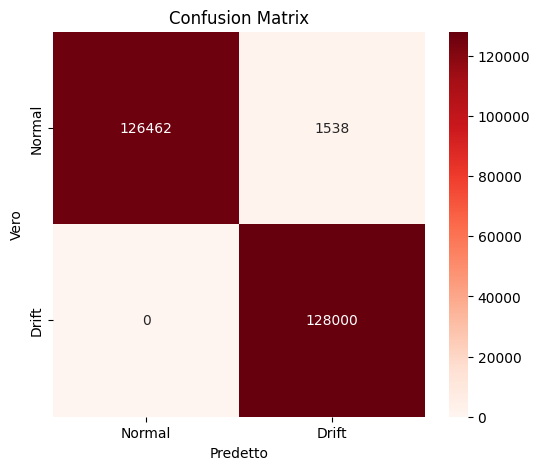

In [18]:
# Classificazione
y_pred = (mae > THRESHOLD).astype(int)

print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
print(f"F1-Score:  {f1_score(y_true, y_pred):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Normal', 'Drift'], yticklabels=['Normal', 'Drift'])
plt.title("Confusion Matrix")
plt.ylabel("Vero")
plt.xlabel("Predetto")
plt.show()

#### Visualizzazione di un singolo attacco
Questo blocco di codice conclude l'analisi visualizzando il risultato dell'attacco Silent Drift in uno spazio tridimensionale che include il tempo. L'obiettivo è mostrare in modo intuitivo come il modello LSTM reagisce all'errore di deriva graduale.

1. **Preparazione all'esperimento**
   * **Iniezione Attacco:** Una singola traiettoria pulita viene estratta e l'attacco Silent Drift viene applicato, introducendo una deriva progressiva (la posizione si sposta costantemente e in modo crescente nel tempo).
   * **Inferenza:** Il modello LSTM Autoencoder esegue la predizione sulla sequenza alterata per produrre la ricostruzione `(traj_recon)`.

2. **Visualizzazione 3D (Spazio + Tempo)**
   * **La linea blu rappresenta l'Input (Deriva Costante)**. Nello spazio 3D, appare come una linea retta quasi perfetta che si muove uniformemente nello spazio mentre il tempo (asse $Z$) avanza. Questa traiettoria è cinematicamente impossibile perché non c'è nessun cambio di velocità o rotta che giustifichi un movimento di deriva così coerente e costante rispetto a dove la nave dovrebbe essere. 
   * **La linea rossa rappresenta il tentativo di ricostruzione del modello.** Invece di seguire la linea retta e impossibile dell'input, la ricostruzione dell'AI mostra un movimento irregolare e frastagliato. Quindi, il modello, incapace di replicare una traiettoria fisicamente non sensata, tenta disperatamente di "piegare" l'output verso la normalità che ha appreso, generando un percorso che è al contempo coerente con i vincoli cinematici ma che non assomiglia all'input.



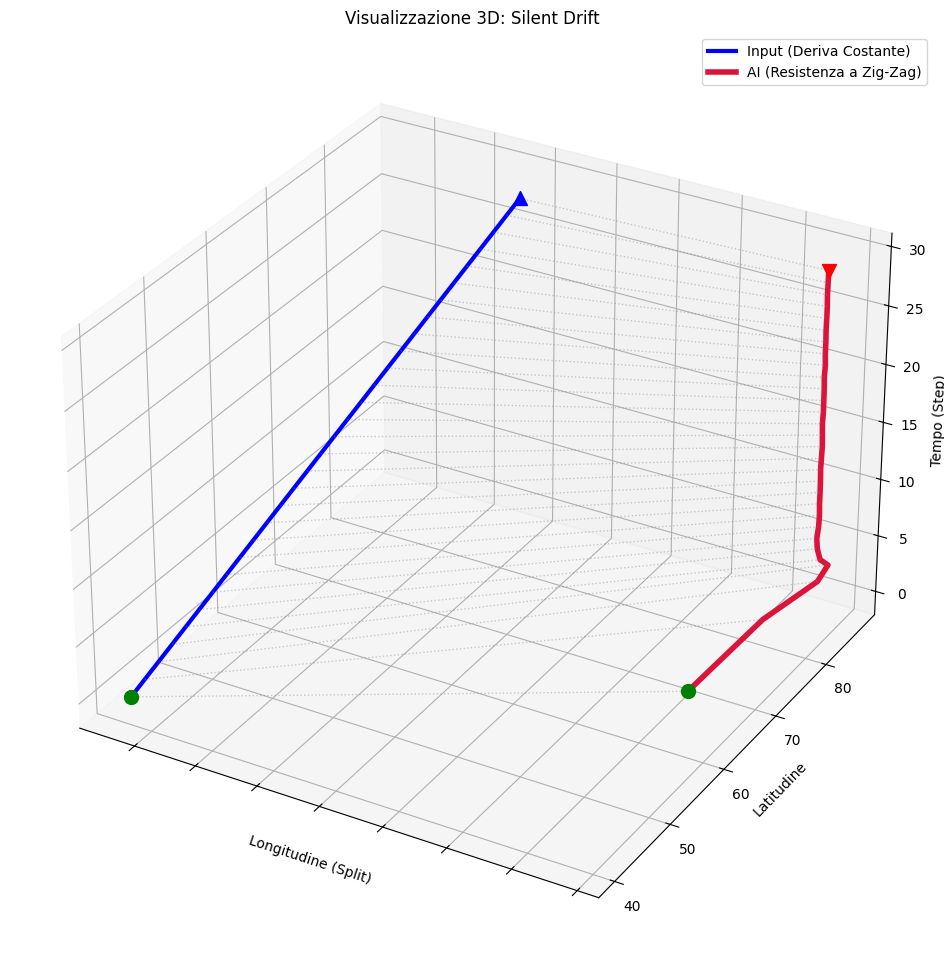

In [9]:
try:
    clean_batch, _ = next(test_gen)
except StopIteration:
    # Ricarica il generatore se è finito
    test_gen = data_generator_v(TEST_FILES, scaler, COLONNE_FEATURES, WINDOW_SIZE, BATCH_SIZE)
    clean_batch, _ = next(test_gen)

drift_batch = apply_silent_drift_attack(clean_batch, drift_rate=0.20)
pred_batch = model.predict(drift_batch, verbose=0)

idx = 0
traj_input = drift_batch[idx] 
traj_recon = pred_batch[idx]  

# Denormalizziamo
traj_input_real = scaler.inverse_transform(traj_input)
traj_recon_real = scaler.inverse_transform(traj_recon)

# Coordinate
lat_in, lon_in = traj_input_real[:, 0], traj_input_real[:, 1]
lat_out, lon_out = traj_recon_real[:, 0], traj_recon_real[:, 1]
time_steps = np.arange(WINDOW_SIZE)

# Offset per separare le rotte (Split View)
offset_lon = (np.max(lon_in) - np.min(lon_in)) * 2.0 
if offset_lon < 0.05: offset_lon = 0.05
lon_out_shifted = lon_out + offset_lon

# PLOT 3D FOCALIZZATO SULLA SERPENTINA
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

# 1. Traccia Input (Blu)
ax.plot(lon_in, lat_in, time_steps, color='blue', linewidth=3, label='Input (Deriva Costante)')
ax.scatter(lon_in[0], lat_in[0], 0, color='green', s=100)
ax.scatter(lon_in[-1], lat_in[-1], 29, color='blue', s=100, marker='^')

# 2. Traccia AI (Rossa)
ax.plot(lon_out_shifted, lat_out, time_steps, color='crimson', linewidth=4, linestyle='-', label='AI (Resistenza a Zig-Zag)')
ax.scatter(lon_out_shifted[0], lat_out[0], 0, color='green', s=100)
ax.scatter(lon_out_shifted[-1], lat_out[-1], 29, color='red', s=100, marker='v')

# 3. Connessioni Neutre (Grigie)
for t in range(WINDOW_SIZE):
    ax.plot([lon_in[t], lon_out_shifted[t]], 
            [lat_in[t], lat_out[t]], 
            [t, t], 
            color='gray', linewidth=1, alpha=0.4, linestyle=':')

# Etichette
ax.set_xlabel('Longitudine (Split)')
ax.set_ylabel('Latitudine')
ax.set_zlabel('Tempo (Step)')
ax.set_title('Visualizzazione 3D: Silent Drift')

# Rimuoviamo i tick X per pulizia
ax.set_xticklabels([])

# Vista ottimale
ax.view_init(elev=30, azim=-60)
ax.legend()

plt.show()